In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE 
from mlxtend.classifier import StackingClassifier
import warnings; warnings.filterwarnings(action='ignore')

In [ ]:
#========================================================
#  载入HOPX111数据集
#========================================================

#111-HOPX-8 image features
def expression_type(s):
    it = {b'normal/over':0, b'low':1}
    return it[s]

pathtrain = "/path of training.txt/"
pathtest = "/path of test.txt/"
datatrain = np.loadtxt(pathtrain, dtype=float, delimiter='\t', converters={2:expression_type})
datatest = np.loadtxt(pathtest, dtype=float, delimiter='\t', converters={2:expression_type})

train_data_nosmo, train_label_nosmo=np.split(datatrain,indices_or_sections=(2,),axis=1) #x为数据，y为标签,axis是分割的方向，1表示横向，0表示纵向，默认为0
#train_data, train_label=np.split(datatrain,indices_or_sections=(8,),axis=1) #x为数据，y为标签,axis是分割的方向，1表示横向，0表示纵向，默认为0
test_data, test_label=np.split(datatest,indices_or_sections=(2,),axis=1) #x为数据，y为标签,axis是分割的方向，1表示横向，0表示纵向，默认为0
#train_data:训练样本，test_data：测试样本，train_label：训练样本标签，test_label：测试样本标签

smo = SMOTE(random_state=1,k_neighbors=5)
#smo = BorderlineSMOTE(kind='borderline-1',random_state=38, k_neighbors=3)
train_data, train_label = smo.fit_resample(train_data_nosmo, train_label_nosmo)

#svmsmo = SVMSMOTE(random_state=4, k_neighbors=5)
#train_data, train_label = svmsmo.fit_resample(train_data_nosmo, train_label_nosmo)

#ada = ADASYN(random_state=8,n_neighbors=3)
#train_data, train_label = ada.fit_resample(train_data_nosmo, train_label_nosmo)

5-fold cross validation:

0.6666666666666666
[[12  5]
 [ 3  4]]
              precision    recall  f1-score   support

         0.0       0.80      0.71      0.75        17
         1.0       0.44      0.57      0.50         7

    accuracy                           0.67        24
   macro avg       0.62      0.64      0.62        24
weighted avg       0.70      0.67      0.68        24

----------------------------------------------------------------
[[60 13]
 [12 61]]
              precision    recall  f1-score   support

         0.0       0.83      0.82      0.83        73
         1.0       0.82      0.84      0.83        73

    accuracy                           0.83       146
   macro avg       0.83      0.83      0.83       146
weighted avg       0.83      0.83      0.83       146

train Confusion Matrix : 
 [[60 13]
 [12 61]]
train Accuracy :  0.8287671232876712
train Specificity :  0.821917808219178
train Sensitivity :  0.8356164383561644
Accuracy: 0.68 (+/- 0.13) [SVM]
Accu

<Figure size 432x288 with 0 Axes>

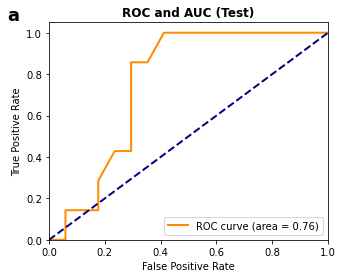

AUC= 0.7563025210084033
-----------------------------------------------------------------------
Accuracy_train= 0.8287671232876712
trainAUC= 0.918746481516232


In [53]:
#========================================================
#  实现Stacking集成
#========================================================
basemodel1 = svm.SVC(C=600.3974,kernel='rbf',gamma=0.0588,decision_function_shape='ovo',probability=True) 
basemodel2 = RandomForestClassifier(random_state=513,max_depth=8,max_features=0.9,min_samples_split=19, n_estimators=10)
#basemodel3 = GradientBoostingClassifier(random_state=923,learning_rate=0.7,max_depth=9, max_features=0.9,min_samples_split=14,n_estimators=153,subsample=0.7)
basemodel3 = GradientBoostingClassifier(random_state=278,learning_rate=0.4,max_depth=13, max_features=0.9,min_samples_split=12,n_estimators=53,subsample=0.5)
#basemodel2 = RandomForestClassifier(random_state=556,max_depth=15,max_features=0.544982,min_samples_split=2, n_estimators=31)
#basemodel3 = GradientBoostingClassifier(random_state=507,learning_rate=0.9,max_depth=13, max_features=0.6,min_samples_split=3,n_estimators=247,subsample=0.9)

meta = LogisticRegression(random_state=10) #meta_classifier  tol=0.0001,C=0.5,random_state=24,max_iter=10

sclf = StackingClassifier(classifiers=[basemodel2, 
                                       #basemodel2,
                                       basemodel3
                                      ], 
                          use_probas=True, #类别概率值作为meta-classfier的输入
                          #average_probas=True,  #是否对每一个类别产生的概率值做平均
                          meta_classifier=meta)

sclf.fit(train_data, train_label)

print('5-fold cross validation:\n')

#模型测试
predict_results = sclf.predict(test_data)
predict_results_train = sclf.predict(train_data)

print(accuracy_score(predict_results, test_label))
conf_mat = confusion_matrix(test_label, predict_results)
print(conf_mat)
print(classification_report(test_label, predict_results))
print("----------------------------------------------------------------")
conf_mat_train = confusion_matrix(train_label, predict_results_train)
print(conf_mat_train)
print(classification_report(train_label, predict_results_train))
cm2 = confusion_matrix(train_label,predict_results_train)
print('train Confusion Matrix : \n', cm2)
total2=sum(sum(cm2))
#####from confusion matrix calculate accuracy
accuracy2=(cm2[0,0]+cm2[1,1])/total2
print ('train Accuracy : ', accuracy2)
specificity2 = cm2[0,0]/(cm2[0,0]+cm2[0,1])
print('train Specificity : ', specificity2 )
sensitivity2 = cm2[1,1]/(cm2[1,0]+cm2[1,1])
print('train Sensitivity : ', sensitivity2)


#5折交叉验证
for clf, label in zip([basemodel2,basemodel3,sclf], ['SVM','RF','GBDT','StackingModel']):
    scores = model_selection.cross_val_score(clf, train_data, train_label, cv=5, scoring='accuracy')  ##1-recall：sensitivity
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
cm1 = confusion_matrix(test_label,predict_results)
print('Confusion Matrix : \n', cm1)
total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)
specificity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Specificity : ', specificity1 )
sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Sensitivity : ', sensitivity1)
    
prob_predict_y_validation = sclf.predict_proba(test_data)#给出带有概率值的结果，每个点所有label的概率和为1
accuracy = sclf.score(test_data,test_label)
predictions_validation = prob_predict_y_validation[:, 1]
fpr, tpr, _ = roc_curve(test_label, predictions_validation)###计算真正率和假正率
roc_auc = auc(fpr, tpr)##计算auc的值
print("-----------------------------------------------------------------------")
print("Accuracy=",accuracy)
print("testAUC=",auc(fpr, tpr))
print(sclf.predict(test_data))

plt.figure()
lw = 2
plt.figure(figsize=(5,4))
out=plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
out=plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
out=plt.xlim([0.0, 1.0])
out=plt.ylim([0.0, 1.05])
out=plt.xlabel('False Positive Rate',fontsize=10)
out=plt.ylabel('True Positive Rate',fontsize=10)
out=plt.title('ROC and AUC (Test)',fontweight='bold',fontsize=12)
plt.text(-0.15,1.06,"a",fontweight='bold',fontsize=18)
out=plt.legend(loc="lower right")
plt.show()
output = out.get_figure()
#output.savefig('/Users/armandayuu/Desktop/AUCtest111.png',dpi=300,bbox_inches='tight')
print("AUC=",auc(fpr, tpr))


prob_predict_y_validation2 = sclf.predict_proba(train_data)#给出带有概率值的结果，每个点所有label的概率和为1
accuracy_train = sclf.score(train_data,train_label)
predictions_validation_train = prob_predict_y_validation2[:, 1]
fpr2, tpr2, _ = roc_curve(train_label, predictions_validation_train)###计算真正率和假正率
roc_auc2 = auc(fpr2, tpr2)##计算auc的值
print("-----------------------------------------------------------------------")
print("Accuracy_train=",accuracy_train)
print("trainAUC=",auc(fpr2, tpr2))

In [ ]:
i=100
train_data_1, valid_data_1, train_label_1, valid_label_1 = train_test_split(train_data_all, train_label_all, test_size=0.2, random_state=i)
train_data_2, valid_data_2, train_label_2, valid_label_2 = train_test_split(train_data_1, train_label_1, test_size=0.25, random_state=i)
train_data_3, valid_data_3, train_label_3, valid_label_3 = train_test_split(train_data_2, train_label_2, test_size=1/3, random_state=i)
train_data_4, valid_data_4, train_label_4, valid_label_4 = train_test_split(train_data_3, train_label_3, test_size=0.5, random_state=i)

print(valid_data_1.shape, valid_data_2.shape, valid_data_3.shape, valid_data_4.shape, train_data_4.shape, train_data_all.shape)
print(valid_label_1.shape, valid_label_2.shape, valid_label_3.shape, valid_label_4.shape, train_label_4.shape, train_label_all.shape)


#print(train_data_nosmo.shape, train_data_all.shape, train_data.shape, valid_data.shape, test_data.shape)

In [ ]:
# 第1段階のモデル作成
#1
first_model_1 = svm.SVC(C=5.5031,kernel='rbf',gamma=0.8459,decision_function_shape='ovo',probability=True) # accuracy
#first_model_1 = svm.SVC(C=299.1,kernel='rbf',gamma=0.000052,decision_function_shape='ovo',probability=True)
#first_model_2 = RandomForestClassifier(random_state=556,max_depth=15,max_features=0.544982,min_samples_split=2, n_estimators=31)
first_model_2 = RandomForestClassifier(random_state=393,max_depth=10,max_features=0.5,min_samples_split=11, n_estimators=236)
first_model_3 = GradientBoostingClassifier(random_state=691,learning_rate=0.1,max_depth=3, max_features=0.9,min_samples_split=6,n_estimators=184,subsample=0.9)
first_model_1.fit(train_data_1, train_label_1)
first_model_2.fit(train_data_1, train_label_1)
first_model_3.fit(train_data_1, train_label_1)

#2
first_model_1_2 = svm.SVC(C=5.5031,kernel='rbf',gamma=0.8459,decision_function_shape='ovo',probability=True)
first_model_2_2 = RandomForestClassifier(random_state=393,max_depth=10,max_features=0.5,min_samples_split=11, n_estimators=236)
first_model_3_2 = GradientBoostingClassifier(random_state=691,learning_rate=0.1,max_depth=3, max_features=0.9,min_samples_split=6,n_estimators=184,subsample=0.9)
train2 = np.row_stack((valid_data_1, train_data_2))
label2 = np.concatenate([valid_label_1, train_label_2],axis=0)
first_model_1_2.fit(train2, label2)
first_model_2_2.fit(train2, label2)
first_model_3_2.fit(train2, label2)

#3
first_model_1_3 = svm.SVC(C=5.5031,kernel='rbf',gamma=0.8459,decision_function_shape='ovo',probability=True)
first_model_2_3 = RandomForestClassifier(random_state=393,max_depth=10,max_features=0.5,min_samples_split=11, n_estimators=236)
first_model_3_3 = GradientBoostingClassifier(random_state=691,learning_rate=0.1,max_depth=3, max_features=0.9,min_samples_split=6,n_estimators=184,subsample=0.9)
train3 = np.row_stack((valid_data_2, valid_data_1,train_data_3))
label3 = np.concatenate([valid_label_2, valid_label_1,train_label_3],axis=0)
first_model_1_3.fit(train3, label3)
first_model_2_3.fit(train3, label3)
first_model_3_3.fit(train3, label3)

#4
first_model_1_4 = svm.SVC(C=5.5031,kernel='rbf',gamma=0.8459,decision_function_shape='ovo',probability=True)
first_model_2_4 = RandomForestClassifier(random_state=393,max_depth=10,max_features=0.5,min_samples_split=11, n_estimators=236)
first_model_3_4 = GradientBoostingClassifier(random_state=691,learning_rate=0.1,max_depth=3, max_features=0.9,min_samples_split=6,n_estimators=184,subsample=0.9)
train4 = np.row_stack((valid_data_3,valid_data_2, valid_data_1,train_data_4))
label4 = np.concatenate([valid_label_3,valid_label_2, valid_label_1,train_label_4],axis=0)
first_model_1_4.fit(train4, label4)
first_model_2_4.fit(train4, label4)
first_model_3_4.fit(train4, label4)
#5
first_model_1_5 = svm.SVC(C=5.5031,kernel='rbf',gamma=0.8459,decision_function_shape='ovo',probability=True)
first_model_2_5 = RandomForestClassifier(random_state=393,max_depth=10,max_features=0.5,min_samples_split=11, n_estimators=236)
first_model_3_5 = GradientBoostingClassifier(random_state=691,learning_rate=0.1,max_depth=3, max_features=0.9,min_samples_split=6,n_estimators=184,subsample=0.9)
train5 = np.row_stack((valid_data_4,valid_data_3,valid_data_2, valid_data_1))
label5 = np.concatenate([valid_label_4,valid_label_3,valid_label_2, valid_label_1],axis=0)
first_model_1_5.fit(train5, label5)
first_model_2_5.fit(train5, label5)
first_model_3_5.fit(train5, label5)
# 結果の検証 
test_pred_1 = first_model_1.predict(test_data)
test_pred_2 = first_model_2.predict(test_data)
test_pred_3 = first_model_3.predict(test_data)


#　各モデル個別の予測精度を平均二乗誤差で確認
print ("モデル1の平均2乗誤差: {:.4f}".format(mean_squared_error(test_label, test_pred_1)))
print ("モデル2の平均2乗誤差: {:.4f}".format(mean_squared_error(test_label, test_pred_2)))
print ("モデル2の平均2乗誤差: {:.4f}".format(mean_squared_error(test_label, test_pred_3)))

In [ ]:
# スタッキングによる予測 Prediction using a stacking ensemble learning 

# 第1段階の予測値(この後、メタモデルの入力に使用) Predictions for validation data
first_pred_1 = first_model_1.predict(valid_data_1)
first_pred_2 = first_model_2.predict(valid_data_1)
first_pred_3 = first_model_2.predict(valid_data_1)
first_pred_1_2 = first_model_1_2.predict(valid_data_2)
first_pred_2_2 = first_model_2_2.predict(valid_data_2)
first_pred_3_2 = first_model_2_2.predict(valid_data_2)
first_pred_1_3 = first_model_1_3.predict(valid_data_3)
first_pred_2_3 = first_model_2_3.predict(valid_data_3)
first_pred_3_3 = first_model_2_3.predict(valid_data_3)
first_pred_1_4 = first_model_1_4.predict(valid_data_4)
first_pred_2_4 = first_model_2_4.predict(valid_data_4)
first_pred_3_4 = first_model_2_4.predict(valid_data_4)
first_pred_1_5 = first_model_1_5.predict(train_data_4)
first_pred_2_5 = first_model_2_5.predict(train_data_4)
first_pred_3_5 = first_model_2_5.predict(train_data_4)

#第1段階の予測値を積み重ねる Stacking predictions by three base models for validation data
stack_pred_1 = np.column_stack((first_pred_1, first_pred_2,first_pred_3))
stack_pred_2 = np.column_stack((first_pred_1_2, first_pred_2_2,first_pred_3_2))
stack_pred_3 = np.column_stack((first_pred_1_3, first_pred_2_3,first_pred_3_3))
stack_pred_4 = np.column_stack((first_pred_1_4, first_pred_2_4,first_pred_3_4))
stack_pred_5 = np.column_stack((first_pred_1_5, first_pred_2_5,first_pred_3_5))
stack_pred_fin = np.row_stack((stack_pred_1,stack_pred_2,stack_pred_3,stack_pred_4,stack_pred_5))

stack_pred_label_fin = np.concatenate([valid_label_1,valid_label_2,valid_label_3,valid_label_4,train_label_4],axis=0)

print(stack_pred_fin.shape)
print(stack_pred_label_fin.shape)

In [ ]:
# メタモデルの学習 Training a meta model using validation data
meta_model = LogisticRegression()
meta_model.fit(stack_pred_fin, stack_pred_label_fin)
#meta_model.fit(stack_pred_1, valid_label_1)

# 各モデルの検証データを積み重ねる Stacking predictions by three base models for test data
stack_test_pred = np.column_stack((test_pred_1,test_pred_2,test_pred_3))

#print("stack_test_pred.shape", stack_test_pred.shape)
#print(stack_test_pred) # matrix size: (Number of test data) X (Number of base models)

# スタッキングの検証 Test of a meta model
meta_test_pred = meta_model.predict(stack_test_pred)
#print ("メタモデルの平均2乗誤差: {:.4f}".format(mean_squared_error(test_label, meta_test_pred)))


cm1 = confusion_matrix(test_label,meta_test_pred)
print('Confusion Matrix : \n', cm1)
total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)
specificity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Specificity : ', specificity1 )
sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Sensitivity : ', sensitivity1)
    
prob_predict_y_validation = meta_model.predict_proba(stack_test_pred)#给出带有概率值的结果，每个点所有label的概率和为1
accuracy = meta_model.score(stack_test_pred,test_label)
predictions_validation = prob_predict_y_validation[:, 1]
fpr, tpr, _ = roc_curve(test_label, predictions_validation)###计算真正率和假正率
roc_auc = auc(fpr, tpr)##计算auc的值
#print("-----------------------------------------------------------------------")
#print("Accuracy=",accuracy)
print("testAUC=",auc(fpr, tpr))
print(meta_model.predict(stack_test_pred))


meta_train_pred = meta_model.predict(stack_pred_fin)
cm1 = confusion_matrix(stack_pred_label_fin,meta_train_pred)
print('Confusion Matrix : \n', cm1)
total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)
specificity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Specificity : ', specificity1 )
sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Sensitivity : ', sensitivity1)

prob_predict_y_validation2 = meta_model.predict_proba(stack_pred_fin)#给出带有概率值的结果，每个点所有label的概率和为1
accuracy_train = meta_model.score(stack_pred_fin,stack_pred_label_fin)
predictions_validation_train = prob_predict_y_validation2[:, 1]
fpr2, tpr2, _ = roc_curve(stack_pred_label_fin, predictions_validation_train)###计算真正率和假正率
roc_auc2 = auc(fpr2, tpr2)##计算auc的值
#print("-----------------------------------------------------------------------")
#print("Accuracy_train=",accuracy_train)
print("trainAUC=",auc(fpr2, tpr2))